<a href="https://colab.research.google.com/github/JuliethLopez/chatbot_simpsons/blob/master/Modelo_clasificador_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de texto 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Con éste código se pretende clasificar un conjunto de frases utilizadas en los dialogos de los simpsons a través de clasificadores de textos de lenguaje natural automáticos. La librería usual para trabajar con datos de lenguaje humano es ntkl, que es la biblioteca más utilizada para interactuar con la utilización del lenguaje natural.

In [2]:
# Librerias
import re 
import csv
import nltk
import pickle
import string
import numpy as np
import pandas as pd
import tensorflow as tf
from shutil import copyfile
from nltk.util import ngrams
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from nltk.tokenize import regexp_tokenize
from sklearn. preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.utils import to_categorical, plot_model

# Define algunas características iniciales

Aquí establecemos la proporción de datos a entrenar, que va a corresponder al 80% del total de los datos. También definimos un arreglo con los caracteres que se desea, representen a los datos de nuestra base. Eliminando así cualquier caracter de uso poco frecuente.

In [3]:
training_portion = 0.8
oov_tok = "<OOV>"

In [4]:
a = np.array([32]) # space
c = np.array(range(97,123)) 
printab = np.hstack((a,c))
printable = np.array([chr(i) for i in printab])   
printable 

array([' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
       'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
       'z'], dtype='<U1')

# Lectura de los datos

La base de datos correspondiente para esta parte del trabajo se consigue con el nombre de "Dialogue Lines of The Simpsons" la cual puede ser consultada en la página de libre acceso kaggle. En principio, éste conjunto de datos contiene personajes, ubicaciones, detalles de los episodios y las líneas de guión de aproximadamente 600 episodios de Simpson, que datan de 1989. Sin embargo, para propositos de esta parte del trabajo la base de datos fue filtrada en excel y se hizo uso únicamente de las columnas "Name of the character who speaks" y "Actual text spoken".

In [5]:
complete_lines = [] 
sentences = []
labels = [] 

In [6]:
# abre el archivo de datos y lo trata como un archivo csv
#file = open('/content/drive/My Drive/Colab Notebooks/DFSMS.csv', 'r') #David
file = open('/content/drive/My Drive/Simpsons Chat bot/Datos/DFSMS.csv', 'r') #Julieth
#file = open('DFSMS.csv', 'r') #Juan
with file as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        # preprocess label
        #label_l = ' '.join(row[0].split()).lower().replace(' ','_') # lower case ans eliminate multiple spaces
        label_l = re.sub(' +', ' ',row[0].lower()) # lower case ans eliminate multiple spaces
        if (len(label_l)>2): # drop with empty label
            label = ''.join(c for c in label_l if c in printable)# filter only printable characters
            label = label.replace(' ','_')
            labels.append(label)
            # preprocess sentence
            #sentence_l = ' '.join(row[1].split()).lower().replace(' ','_') # lower case ans eliminate multiple spaces
            sentence_l = re.sub(' +', ' ',row[1].lower())
            sentence = ''.join(c for c in sentence_l if c in printable)
            complete_lines.append(row[0] + ': '+ row[1])
            sentences.append(sentence)
 

# resumen de la lectura            
print("labels:",len(labels))
print("complete_lines:",len(complete_lines))
print("sentences",len(sentences))

labels: 64773
complete_lines: 64773
sentences 64773


In [7]:
# Tercer linea
print(labels[20]+'\n')
print(complete_lines[20]+'\n')
print(sentences[20]+'\n')

lisa_simpson

Lisa Simpson: But I need you too.

but i need you too



### Grafico de frecuencias de los personajes

A continuación, se podrá visualizar un gráfico de barras en el cual representamos el número de frases asociadas a cada personaje.

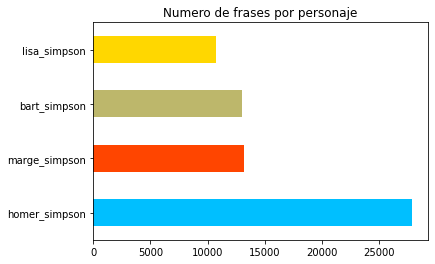

In [8]:
frec = pd.value_counts(labels)
plot = frec.plot(kind='barh',title='Numero de frases por personaje',color=['deepskyblue','orangered','darkkhaki','gold'])

In [9]:
n_lines = frec.values[1]
n_lines

13172

Como se pudo observar en el gráfico anterior y como era de esperar, la cantidad de frases asociadas al personaje Homero es mucho mayor que la de los otros personakes. En consecuencia, se reducirá la cantidad de frases correspondientes a este personaje.

In [10]:
np.random.seed(101)
homer_index = []

for i in range(len(labels)):
  if labels[i] == 'homer_simpson':
    homer_index.append(i)

homer_r = np.random.choice(homer_index,n_lines,replace=False)

In [11]:
np.random.seed(101)
marge_index = []

for i in range(len(labels)):
  if labels[i] == 'marge_simpson':
    marge_index.append(i)

In [12]:
np.random.seed(101)
bart_index = []

for i in range(len(labels)):
  if labels[i] == 'bart_simpson':
    bart_index.append(i)

In [13]:
np.random.seed(101)
lisa_index = []

for i in range(len(labels)):
  if labels[i] == 'lisa_simpson':
    lisa_index.append(i)

In [14]:
sentences = np.array(sentences)
labels = np.array(labels)

homer_s = sentences[homer_r]
marge_s = sentences[marge_index]
bart_s = sentences[bart_index]
lisa_s = sentences[lisa_index]

homer_l = labels[homer_r]
marge_l = labels[marge_index]
bart_l = labels[bart_index]
lisa_l = labels[lisa_index]

In [15]:
homer_s = homer_s.tolist()
marge_s = marge_s.tolist()
bart_s = bart_s.tolist()
lisa_s = lisa_s.tolist()

homer_l = homer_l.tolist()
marge_l = marge_l.tolist()
bart_l = bart_l.tolist()
lisa_l = lisa_l.tolist()

In [16]:
sentences = [homer_s + marge_s + bart_s + lisa_s]
np.shape(sentences)

(1, 50095)

In [17]:
labels = [homer_l + marge_l + bart_l + lisa_l]
np.shape(labels)

(1, 50095)

In [18]:
sentences = sentences[0]
labels = labels[0]

Aquí podremos visualizar la cantidad final de frases correspondientes a cada personaje para el resto de nuestro trabajo. Observemos que las frases del personaje Homero se redujo exactamente a la cantidad de frases asociadas al personaje marge, que corresponde a 13172 frases. También se puede observar que el total de datos con el que vamos a trabajar tiene un tamaño de 50095.

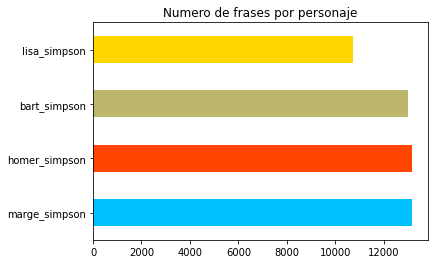

In [19]:
frec = pd.value_counts(labels)
plot = frec.plot(kind='barh',title='Numero de frases por personaje',color=['deepskyblue','orangered','darkkhaki','gold'])

# Grafica de frecuencia de n-gramas

Muchas veces estamos interesados en saber que tan frecuente se hace la aparición de una palabra, dos palabras juntas o n palabras juntas. Los n gramas son un tipo de modelo probabilistico, el cual permite hacer una predicción estadística del próximo elemento en este caso, de una cadena de caracteres o palabras, la cual ha sido sucedida hasta el momento. Esto nos permite extraer caracteristicas comúnes de este gran conjunto de texto que estamos utilizando.

### Trigramas

Para cumplir los objetivos de este proyecto, primero juntamos todo el texto en una sola línea y separamos cada palabra con un espacio. Luego formamos un arreglo que contiene cada pa

In [20]:
#Juntamos todo el texto en una sola linea
wordtk = ' '.join(sentences)

#Para dividir las frases
tokenstk = regexp_tokenize(wordtk, pattern="\w+")
tokenstk[:10]

['the',
 'power',
 'of',
 'dreaming',
 'has',
 'convinced',
 'me',
 'the',
 'threat',
 'is']

In [21]:
trigrama = ngrams(tokenstk,3)
trigrama = [' '.join(grams) for grams in trigrama]
trigrama[:5]

['the power of',
 'power of dreaming',
 'of dreaming has',
 'dreaming has convinced',
 'has convinced me']

In [22]:
freq = nltk.FreqDist(trigrama) #frecuencia de los tokens

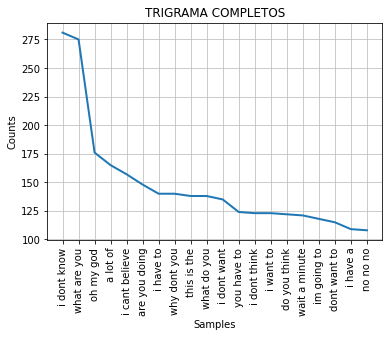

Trigramas completos unicos: 367550


In [23]:
# Gráfica con los trigramas COMPLETOS
freq.plot(20, cumulative=False, title = "TRIGRAMA COMPLETOS")
print("Trigramas completos unicos:", len(freq))

In [24]:
eliminar = [] #filtramos tokens que se repiten mas de una vez
for key,val in freq.items():
  if (200>val>3):
    eliminar.append(str(key))

trigrama_limpio = []
for i in trigrama:
  if i in eliminar:
    trigrama_limpio.append(i)

freqnew = nltk.FreqDist(trigrama_limpio)

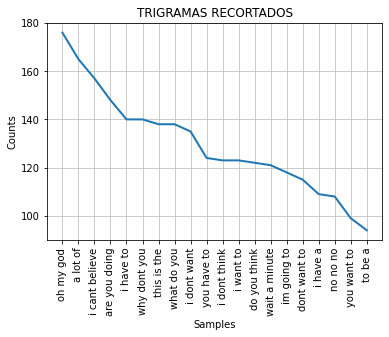

Trigramas recortados unicos: 8316


In [25]:
# Gráfica con los trigramas RECORTADOS
freqnew.plot(20, cumulative=False, title = "TRIGRAMAS RECORTADOS")
print("Trigramas recortados unicos:", len(freqnew))

In [26]:
#comparacion de trigramas
print("Trigramas completos unicos:", len(freq))
print("Trigramas recortados unicos:", len(freqnew))

Trigramas completos unicos: 367550
Trigramas recortados unicos: 8316


### Bigramas

In [27]:
bigrama = ngrams(tokenstk,2)
bigrama = [' '.join(grams) for grams in bigrama]
bigrama[:5]

['the power', 'power of', 'of dreaming', 'dreaming has', 'has convinced']

In [28]:
freqb = nltk.FreqDist(bigrama) #frecuencia de los tokens

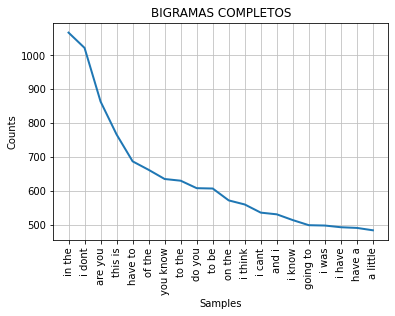

Bigramas completos unicos: 187426


In [29]:
# Gráfica con los bigramas COMPLETOS
freqb.plot(20, cumulative=False, title = "BIGRAMAS COMPLETOS")
print("Bigramas completos unicos:", len(freqb))

In [30]:
eliminarb = [] #filtramos tokens que se repiten mas de una vez
for key,val in freqb.items():
  if (700>val>100):
    eliminarb.append(str(key))

bigrama_limpio = []
for i in bigrama:
  if i in eliminarb:
    bigrama_limpio.append(i)

freqbnew = nltk.FreqDist(bigrama_limpio)

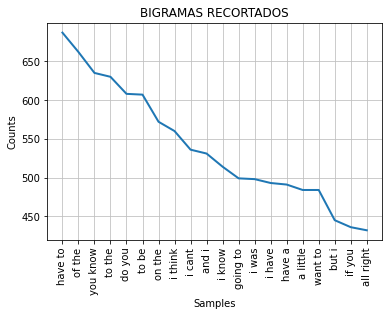

Bigramas recortados unicos: 307


In [31]:
# Gráfica con los Bigramas
freqbnew.plot(20, cumulative=False, title = "BIGRAMAS RECORTADOS")
print("Bigramas recortados unicos:", len(freqbnew))

In [32]:
#comparacion de bigramas
print("Bigramas completos unicos:", len(freqb))
print("Bigramas recortados unicos:", len(freqbnew))

Bigramas completos unicos: 187426
Bigramas recortados unicos: 307


# Vocabulario
### Trigramas

Aunque trigrama_limpio ya no tiene ni los tokens con repitencias muy bajas ni muy altas, contiene tokens repetidos, por eso, para el vocabulario de CountVectorizer utilizameros los freqnew.keys() que contiene los tokens unicos.

In [33]:
vectorizer3 = CountVectorizer(vocabulary=freqnew.keys(), ngram_range=(3,3))

Las siuientes dos celdas de código se utilizaron para guardar los trigramas y subir los datos a drive para poder llamarlos desde el cuaderno *pre-chatbot*.

In [34]:
#guarda los freqnew como .pickle
#with open('freqnew.pickle', 'wb') as f:
#    pickle.dump(freqnew, f)

In [35]:
#guarda freqnew.pickle en drive
#copyfile("freqnew.pickle", "/content/drive/My Drive/Simpsons Chat bot/Modelos guardos/freqnew.pickle")

In [36]:
X3 = vectorizer3.fit_transform(sentences)

In [37]:
F3 = vectorizer3.get_feature_names() #Mapeo de matriz de índices de enteros a nombres.
F3[:10]

['the power of',
 'what the hell',
 'the hell is',
 'hell is that',
 'that oh my',
 'my life is',
 'oh no not',
 'wait wait wait',
 'i didnt know',
 'didnt know you']

In [38]:
sequences = X3.toarray() #arreglo
print("longitud",len(X3.toarray()))

longitud 50095


Como vemos en la tabla, cada fila corresponde a una frase de nuestro __sentences__ y cada columna corresponde a un trigrama, por lo tanto la tabla es de (50095 × 8316),

  - sentences: 50095
  - Trigramas unicos con sus frecuencias:  8316

In [39]:
pd.DataFrame(sequences,columns=vectorizer3.get_feature_names())

,the power of,what the hell,the hell is,hell is that,that oh my,my life is,oh no not,wait wait wait,i didnt know,didnt know you,know you were,all i had,i had to,to the house,the house and,tickets to the,the super bowl,give you a,just give me,give me one,leave me alone,i got a,got a date,a date with,date with my,are you doing,you doing here,oh yeah thats,what is this,is this place,just a second,but im sure,youre up to,up to it,now wait a,wait a minute,im not gonna,father of the,of the year,guy in the,...,earth peace on,take us to,barts making faces,and dad i,get it bart,sure i guess,dad mr burns,lu lu lu,one is the,dont worry bart,dad you have,im lisa simpson,voted for bob,bart dont you,no dad its,dad im sorry,bleeding gums murphy,oh dad im,bart stop it,be such a,how can we,dad and bart,used to date,cheated cheated cheated,my names lisa,im a vegetarian,if i win,what is going,larry flynt larry,flynt larry flynt,my brother is,to me about,zap zap zap,fine fine fine,goorsha goorsha goorsha,i denounce thee,lisa simpson lisa,simpson lisa simpson,the loneliest number,sad sad sad
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50090,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
50091,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
50092,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
50093,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Bigramas
Aunque bigrama_limpio ya no tiene ni los tokens con repitencias muy bajas ni muy altas, contiene tokens repetidos, por eso, para el vocabulario de CountVectorizer utilizameros los freqbnew.keys() que contiene los tokens unicos.

In [40]:
vectorizer2 = CountVectorizer(vocabulary=freqbnew.keys(), ngram_range=(2,2))

Las siuientes dos celdas de código se utilizaron para guardar los bigramas y subir los datos a drive para poder llamarlos desde el cuaderno *pre-chatbot*.

In [41]:
#guarda los freqbnew como .pickle
#with open('freqbnew.pickle', 'wb') as f:
#    pickle.dump(freqbnew, f)

In [42]:
#guarda freqbnew.pickle en drive
#copyfile("freqbnew.pickle", "/content/drive/My Drive/Simpsons Chat bot/Modelos guardos/freqbnew.pickle")

In [43]:
X2 = vectorizer2.fit_transform(sentences)

In [44]:
F2 = vectorizer2.get_feature_names() #Mapeo de matriz de índices de enteros a nombres.
F2[:10]

['we have',
 'what the',
 'is that',
 'oh my',
 'my life',
 'oh no',
 'now i',
 'i didnt',
 'you were',
 'i had']

In [45]:
sequences_b = X2.toarray() #arreglo
print("longitud",len(X2.toarray()))

longitud 50095


Como vemos en la tabla, cada fila corresponde a una frase de nuestro __sentences__ y cada columna corresponde a un bigrama, por lo tanto la tabla es de (50095 × 307),

  - sentences: 50095
  - Bigramas unicos con sus frecuencias: 307

In [46]:
pd.DataFrame(sequences_b,columns=vectorizer2.get_feature_names())

,we have,what the,is that,oh my,my life,oh no,now i,i didnt,you were,i had,to the,the house,and a,have you,you a,give me,i got,got a,with my,what are,you doing,oh yeah,thats a,is this,just a,will be,but im,im sure,up to,wait a,a minute,im not,of the,the last,the world,can i,is the,the best,of my,mr burns,...,see you,you like,was a,of your,im sorry,you didnt,you really,at me,dad you,a great,make it,you mean,so much,thats the,i really,like this,when you,used to,what about,ill be,im so,the one,your father,one of,i hope,to your,is so,what a,looks like,you do,we were,ive never,im going,dad i,think you,homer i,got to,mom i,it to,can we
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50090,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
50091,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
50092,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
50093,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Juntamos los bigramas y trigramas
Como cada fila corresponde a una frase de nuestro __sentences__ y cada columna corresponde a los bigramas y trigramas, nuestra tabla es de (50095 × 8623) donde:

  - train_sentences: 50095
  - Trigramas unicos con sus frecuencias(8623) + bigramas unicos con sus frecuencias(307):  8623

In [47]:
print("Trigramas recortados unicos + Bigramas recortador unicos:", len(freqnew)+len(freqbnew))

Trigramas recortados unicos + Bigramas recortador unicos: 8623


In [48]:
sequences_bt = np.concatenate((sequences, sequences_b), axis=1)
#tamaño de los datos
type(sequences_bt)

numpy.ndarray

In [49]:
sequences_bt[:5]

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [50]:
sequences_bt_new = []
labels_new = []
for i in range(0,len(sequences_bt)):
  if sum(sequences_bt[i,]) != 0:
    labels_new.append(labels[i])
    sequences_bt_new.append(sequences_bt[i,])

sequences_bt = np.array(sequences_bt_new)

In [51]:
labels = labels_new
print("sequences_bt",np.shape(sequences_bt))
print("labels",np.shape(labels))

sequences_bt (28105, 8623)
labels (28105,)


In [52]:
pd.value_counts(labels)

marge_simpson    8041
homer_simpson    7435
bart_simpson     6703
lisa_simpson     5926
dtype: int64

# Labels
### Labels a one hot

In [53]:
label_size = 5
label_tokenizer = Tokenizer(num_words = label_size,oov_token=oov_tok, filters = '')
label_tokenizer.fit_on_texts(labels)

label_seq = np.array(label_tokenizer.texts_to_sequences(labels))

# flatten the nested list and tranaform to an np array
label_seq = np.array([item for items in label_seq for item in items])
print(len(label_seq))

28105


In [54]:
pd.value_counts(label_seq)

2    8041
3    7435
4    6703
1    5926
dtype: int64

In [55]:
label_seq[17000]
#3 homero
#2 marge
#4 bart
#1 lisa

4

In [56]:
#Creamos etiquetas numericas
encoder = LabelEncoder()

encoder.fit(label_seq)
labels = encoder.transform(label_seq)

In [57]:
pd.value_counts(labels)
#2 homero
#1 marge
#3 bart
#0 lisa

1    8041
2    7435
3    6703
0    5926
dtype: int64

In [58]:
labels[17000]

3

In [59]:
# Codificación One-Hot 
num_classes = label_size-1
labels_codf = tf.keras.utils.to_categorical(labels, num_classes)

In [60]:
labels_codf[17000]  
#[0. 0. 1. 0.] homero
#[0. 1. 0. 0.] marge
#[0. 0. 0. 1.] bart
#[1. 0. 0. 0.] lisa

array([0., 0., 0., 1.], dtype=float32)

### Nuerico a texto

In [61]:
label_tokenizer.sequences_to_texts([[1,2,3,4,5]]) #NO APARECE LISA

['<OOV> marge_simpson homer_simpson bart_simpson <OOV>']

In [62]:
reverse_word_map = dict(map(reversed, label_tokenizer.word_index.items()))

# Function takes a tokenized sentence and returns the words
def sequence_to_text(list_of_indices):
    # Looking up words in dictionary
    label = [reverse_word_map.get(i) for i in list_of_indices]
    return(label)

#inversa: de token a palabra
sequence_to_text([2,3,4,5]) #SI APERECE LISA

['marge_simpson', 'homer_simpson', 'bart_simpson', 'lisa_simpson']

# Separa datos de entrenamiento y validación
### Aleatorización de los datos
sequences_bt
labels_codf

In [63]:
# index to sample
n = len(sequences_bt)
sequences_bt = np.array(sequences_bt)
labels_codf = np.array(labels_codf)

np.random.seed(101)
sequences_id  = np.random.permutation(n)
sequences = sequences_bt[sequences_id]
labels = labels_codf[sequences_id]

In [64]:
print(labels.shape)
print(sequences.shape)

(28105, 4)
(28105, 8623)


### Grupo de entrenamiento
Definimos el tamaño de los datos de entrenamiento, que corresponde al 80% de la totalidad de los datos. Definimos "train_sencences" como el conjunto de frases de entrenamiento y "train_labels" como las etiquetas de entrenamiento, las cuales nos serviran como identificadores del conjunto de frases de entrenamiento.

In [65]:
train_size = int(n * training_portion) 

train_sentences = sequences[:train_size]
train_labels = labels[:train_size]
print("train_sentences:",len(train_sentences))
print("train_labels:",len(train_labels),"\n")

train_sentences: 22484
train_labels: 22484 



### Grupo de validación
Definimos el tamaño de los datos de validación, que corresponde al 10% de la totalidad de los datos. Definimos "validation_sentences" como el conjunto de frases de validación y "validation_labels" como las etiquetas de validación, las cuales nos serviran como identificadores del conjunto de frases de validación.

In [66]:
validation_sentences = sequences[train_size:] 
validation_labels = labels[train_size:] 
print("validation_sentences:",len(validation_sentences)) 
print("validation_labels:",len(validation_labels),"\n") 

validation_sentences: 5621
validation_labels: 5621 



### Dividimos test y validación
Recordemos que el grupo de validacion (tanto las frases como los labels) que se ha tenido hasta ahora es el 20% de los datos iniciales, dividiremos este grupo es dos para tomar el 10% del total de los datos iniciales para la validacion interna y el otro 10% para la valicacion externa. Ademas tenga en cuenta que los porcentajes de datos son __aproximados__ debido a la transformacion y limpieza de los datos que se ha hecho.

Tomamos primero los datos de test(validacion externa) y luego los de validacion interna(validation_sequences_bt) porque renombraremos esa variable con el porcentaje de datos especificado arriba.

In [67]:
validation_portion = 0.5
validation_size = int(len(validation_sentences) * validation_portion)
validation_size # 10% del total

test_sequences = validation_sentences[validation_size:] # Frases de test
test_labels = validation_labels[validation_size:] # Etiquetas de test

validation_sequences = validation_sentences[:validation_size] # Frases de validacion 
validation_labels = validation_labels[:validation_size] # Etiquetas de validacion

In [68]:
#verificacion de tamaños
print("validation_sequences_bt",train_sentences.shape) #entrenamiento
print("validation_labels_codf",train_labels.shape)
print("test_sequences_bt",test_sequences.shape) #validacion externa
print("test_labels_codf",test_labels.shape)
print("validation_sequences_bt",validation_sequences.shape) #validacion interna
print("validation_labels_codf",validation_labels.shape)

validation_sequences_bt (22484, 8623)
validation_labels_codf (22484, 4)
test_sequences_bt (2811, 8623)
test_labels_codf (2811, 4)
validation_sequences_bt (2810, 8623)
validation_labels_codf (2810, 4)


In [69]:
validation_labels[:10]

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]], dtype=float32)

# Construccion del Modelo

In [ ]:
num_frases_training, num_ngrams, = np.shape(train_sentences)

print("num_frases_training", num_frases_training) #se espera 21025
print("num_ngrams:", num_ngrams) #se espera 6379

num_frases_training 22484
num_ngrams: 8623


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=10
    )
# This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(8623, activation='relu', input_shape=(num_ngrams,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4311, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2160, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1080, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 8623)              74364752  
_________________________________________________________________
dropout_29 (Dropout)         (None, 8623)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 4311)              37178064  
_________________________________________________________________
dropout_30 (Dropout)         (None, 4311)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 2160)              9313920   
_________________________________________________________________
dropout_31 (Dropout)         (None, 2160)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 1080)             

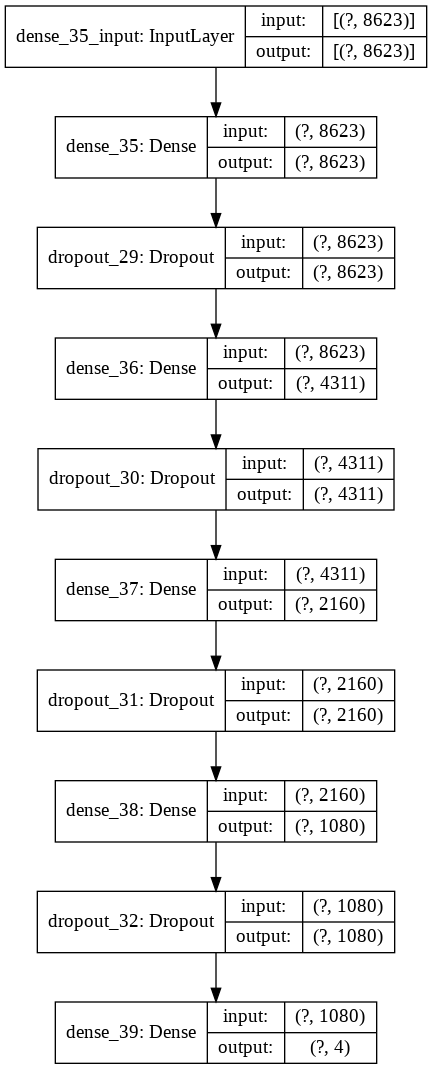

In [ ]:
model.summary()
img_path = 'Imagenes'
plot_model(model, to_file=img_path +'clasificacion.png', show_shapes=True)

# Entrenamiento del modelo

|dropout|F. de activación| dense |loss_train |accuracy_train |loss_validation |accuracy_validation |Ephoc|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|4|tanh(1),relu(3)|5|0.7715|0.6028|1.2662|0.4657|7|
|4|tanh(4),relu(1)|6|0.9419|0.5285|1.1128|0.4241|6|
|5|tanh(2),relu(3)|6|0.7683|0.6877|1.7956|0.4490|10|
|5|tanh(0),relu(5)|6|0.4636|0.7820|2.1792|0.4489|10|
|4|tanh(0),relu(5)|6|0.5599|0.7633|1.7796|0.4444|7|
|3|tanh(3),relu(2)|6|0.5243|0.7608|2.0161|0.4381|9|
|4|tanh(5),relu(1)|7|0.9163|0.6148|1.3061|0.4359|5|
|4|tanh(5),relu(1)|7|1.0490|0.5492|1.1830|0.4670|5|
|4|tanh(1),relu(4)|7|0.9413|0.5382|1.0868 |0.4551|8|
|6|tanh(0),relu(7)|8|0.7479|0.6439|1.3333 |0.4498|6|
|1|tanh(0),relu(2)|3|0.5127|0.7513|1.7194 |0.4567|6|


In [ ]:
num_epochs = 50
history = model.fit(train_sentences, train_labels, epochs=num_epochs, validation_data=(validation_sequences,validation_labels),batch_size=32, verbose=True, callbacks=[callback])

print("\nEn la epoca", len(history.history['val_accuracy']), "la precision de validación dejó de mejorar.")

Epoch 1/50
703/703 [==============================] - 28s 39ms/step - loss: 1.3805 - accuracy: 0.2819 - val_loss: 1.3802 - val_accuracy: 0.2851
Epoch 2/50
703/703 [==============================] - 27s 39ms/step - loss: 1.3797 - accuracy: 0.2869 - val_loss: 1.3800 - val_accuracy: 0.2851
Epoch 3/50
703/703 [==============================] - 27s 39ms/step - loss: 1.3789 - accuracy: 0.2876 - val_loss: 1.3796 - val_accuracy: 0.2851
Epoch 4/50
703/703 [==============================] - 28s 39ms/step - loss: 1.3793 - accuracy: 0.2857 - val_loss: 1.3793 - val_accuracy: 0.2851
Epoch 5/50
703/703 [==============================] - 27s 39ms/step - loss: 1.3784 - accuracy: 0.2889 - val_loss: 1.3791 - val_accuracy: 0.2851
Epoch 6/50
703/703 [==============================] - 27s 38ms/step - loss: 1.3782 - accuracy: 0.2886 - val_loss: 1.3788 - val_accuracy: 0.2851
Epoch 7/50
703/703 [==============================] - 27s 38ms/step - loss: 1.3774 - accuracy: 0.2893 - val_loss: 1.3784 - val_accuracy:

Las siuientes dos celdas de código se utilizaron para guardar el modelo, comprimir los datos en una carpeta y subir los datos a drive para poder llamarlos desde el cuaderno *pre-chatbot*.

In [ ]:
#model.save('clasificador')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: clasificador/assets


In [ ]:
#!zip -r clasificador.zip clasificador

  adding: clasificador/ (stored 0%)
  adding: clasificador/saved_model.pb (deflated 90%)
  adding: clasificador/assets/ (stored 0%)
  adding: clasificador/variables/ (stored 0%)
  adding: clasificador/variables/variables.index (deflated 56%)
  adding: clasificador/variables/variables.data-00001-of-00002 (deflated 8%)
  adding: clasificador/variables/variables.data-00000-of-00002 (deflated 78%)


In [ ]:
#from shutil import copyfile
#copyfile("clasificador.zip", "/content/drive/My Drive/Simpsons Chat bot/Modelos guardos/clasificador.zip")

'/content/drive/My Drive/Simpsons Chat bot/Modelos guardos/clasificador.zip'

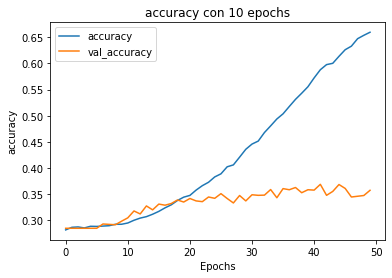

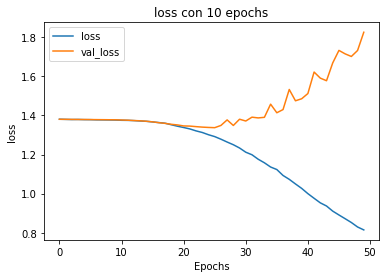

In [ ]:
def plot_graphs(history, string):
  plt.title(string+' con 10 epochs')
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

#model = tf.keras.Sequential([
#    tf.keras.layers.Dense(8623, activation='relu', input_shape=(num_ngrams,)),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(4311, activation='relu'),
#    tf.keras.layers.Dropout(0.4),
#    tf.keras.layers.Dense(2155, activation='relu'),
#    tf.keras.layers.Dropout(0.3),
#    tf.keras.layers.Dense(1077, activation='relu'),
#    tf.keras.layers.Dropout(0.2),
#    tf.keras.layers.Dense(538, activation='relu'),
#    tf.keras.layers.Dropout(0.1),
#    tf.keras.layers.Dense(269, activation='relu'),
#    tf.keras.layers.Dropout(0.1),
#    tf.keras.layers.Dense(4, activation='softmax')
#])
#model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

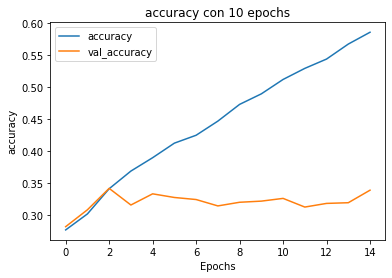

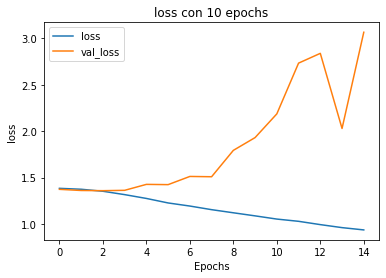

In [ ]:
def plot_graphs(history, string):
  plt.title(string+' con 10 epochs')
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

#model = tf.keras.Sequential([
#    tf.keras.layers.Dense(8623, activation='relu', input_shape=(num_ngrams,)),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(4311, activation='relu'),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(2155, activation='relu'),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(1077, activation='relu'),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(538, activation='relu'),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(269, activation='relu'),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(4, activation='softmax')
#])
#model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

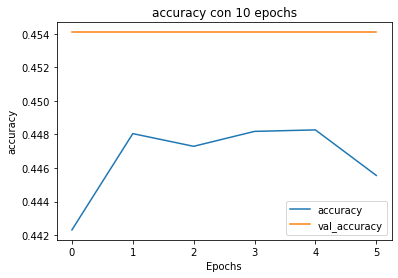

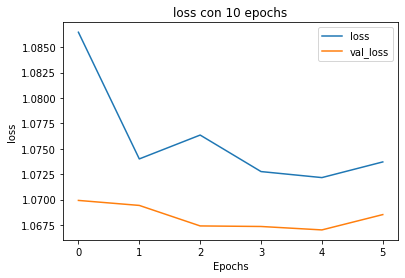

In [ ]:
def plot_graphs(history, string):
  plt.title(string+' con 10 epochs')
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

#model = tf.keras.Sequential([
#    tf.keras.layers.Dense(8623, activation='relu', input_shape=(num_ngrams,)),
#    tf.keras.layers.Dense(4311, activation='relu'),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(2874, activation='relu'),
#    tf.keras.layers.Dense(2155, activation='relu'),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(1724, activation='relu'),
#    tf.keras.layers.Dense(1437, activation='tanh'),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(1231, activation='relu'),
#    tf.keras.layers.Dense(958, activation='relu'),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(862, activation='relu'),
#    tf.keras.layers.Dense(718, activation='relu'),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(574, activation='relu'),
#    tf.keras.layers.Dense(269, activation='relu'),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(4, activation='softmax')
#])
#model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

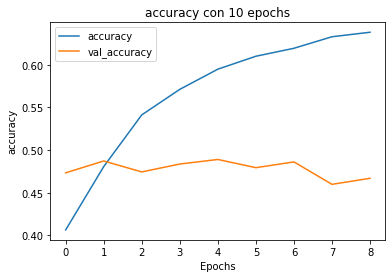

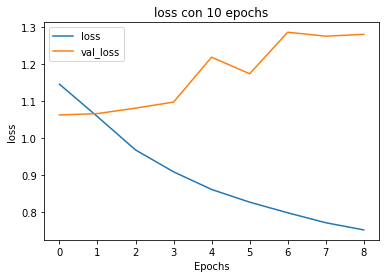

In [ ]:
def plot_graphs(history, string):
  plt.title(string+' con 10 epochs')
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

#model = tf.keras.Sequential([
#    tf.keras.layers.Dense(8623, activation='tanh', input_shape=(num_ngrams,)),
#    tf.keras.layers.Dropout(0.5),                     
#    tf.keras.layers.Dense(4311, activation='tanh'),
#    tf.keras.layers.Dropout(0.4),
#    tf.keras.layers.Dense(1077, activation='sigmoid', activity_regularizer=tf.keras.regularizers.l2(1e-4)),
#    tf.keras.layers.Dense(538, activation='tanh'),
#    tf.keras.layers.Dropout(0.2),
#    tf.keras.layers.Dense(269, activation='tanh'),
#    tf.keras.layers.Dropout(0.1),
#    tf.keras.layers.Dense(4, activation='softmax')
#])
#model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

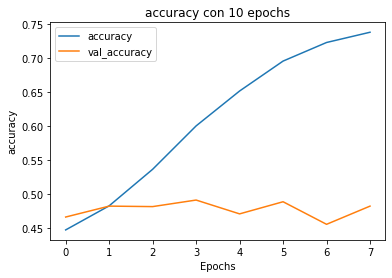

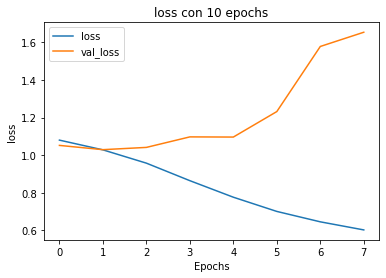

In [ ]:
def plot_graphs(history, string):
  plt.title(string+' con 10 epochs')
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

#model = tf.keras.Sequential([
#    tf.keras.layers.Dense(8623, activation='relu', input_shape=(num_ngrams,)),
#    tf.keras.layers.Dropout(0.5),                     
#    tf.keras.layers.Dense(4311, activation='relu'),
#    tf.keras.layers.Dropout(0.4),
#    tf.keras.layers.Dense(2155, activation='relu'),
#    tf.keras.layers.Dropout(0.3),
#    tf.keras.layers.Dense(1077, activation='tanh', activity_regularizer=tf.keras.regularizers.l2(1e-4)),
#    tf.keras.layers.Dense(538, activation='relu'),
#    tf.keras.layers.Dropout(0.2),
#    tf.keras.layers.Dense(269, activation='relu'),
#    tf.keras.layers.Dropout(0.1),
#    tf.keras.layers.Dense(4, activation='softmax')
#])
#model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

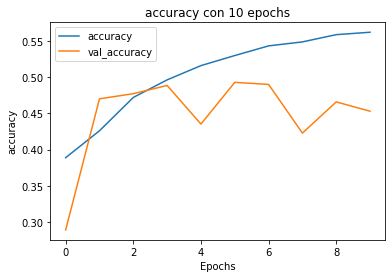

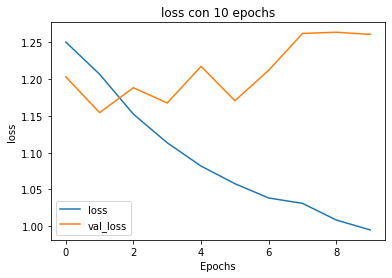

In [ ]:
def plot_graphs(history, string):
  plt.title(string+' con 10 epochs')
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

#model = tf.keras.Sequential([
#    tf.keras.layers.Dense(8623, activation='tanh', input_shape=(num_ngrams,)),
#    tf.keras.layers.Dropout(0.5),                     
#    tf.keras.layers.Dense(4311, activation='tanh'),
#    tf.keras.layers.Dropout(0.4),
#    tf.keras.layers.Dense(2155, activation='tanh'),
#    tf.keras.layers.Dropout(0.3),
#    tf.keras.layers.Dense(1077, activation='tanh', activity_regularizer=tf.keras.regularizers.l2(1e-4)),
#    tf.keras.layers.Dense(538, activation='tanh'),
#    tf.keras.layers.Dropout(0.2),
#    tf.keras.layers.Dense(269, activation='tanh'),
#    tf.keras.layers.Dropout(0.1),
#    tf.keras.layers.Dense(4, activation='softmax')
#])
#model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

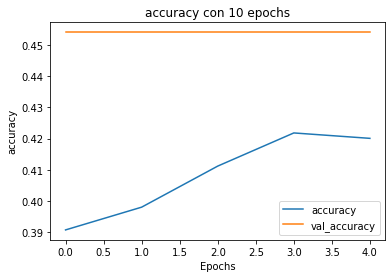

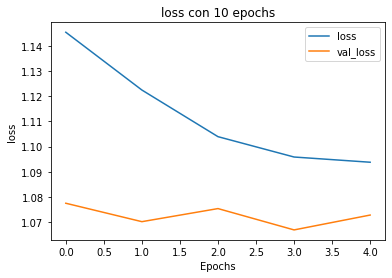

In [ ]:
def plot_graphs(history, string):
  plt.title(string+' con 10 epochs')
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

#model = tf.keras.Sequential([
#    tf.keras.layers.Dense(8623, activation='sigmoid', input_shape=(num_ngrams,)),
#    tf.keras.layers.Dropout(0.5),                     
#    tf.keras.layers.Dense(4311, activation='tanh'),
#    tf.keras.layers.Dropout(0.4),
#    tf.keras.layers.Dense(2155, activation='tanh'),
#    tf.keras.layers.Dropout(0.3),
#    tf.keras.layers.Dense(1077, activation='sigmoid'),
#    tf.keras.layers.Dropout(0.2),
#    tf.keras.layers.Dense(538, activation='tanh'),
#    tf.keras.layers.Dropout(0.1),
#    tf.keras.layers.Dense(269, activation='tanh'),
#    tf.keras.layers.Dropout(0.1),
#    tf.keras.layers.Dense(4, activation='softmax')
#])
#model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

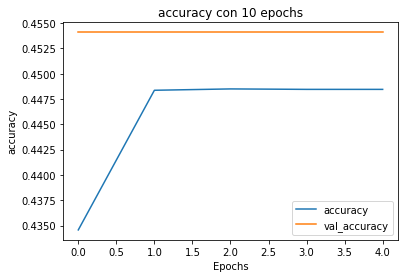

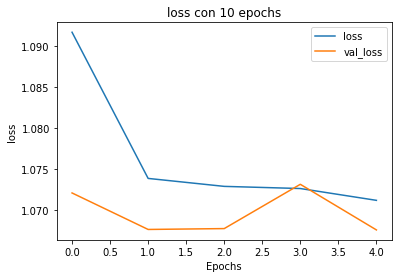

In [ ]:
def plot_graphs(history, string):
  plt.title(string+' con 10 epochs')
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

#model = tf.keras.Sequential([
#    tf.keras.layers.Dense(8623, activation='relu', input_shape=(num_ngrams,)),
#    tf.keras.layers.Dropout(0.5),                     
#    tf.keras.layers.Dense(4311, activation='sigmoid'),
#    tf.keras.layers.Dropout(0.4),
#    tf.keras.layers.Dense(2155, activation='relu'),
#    tf.keras.layers.Dropout(0.3),
#    tf.keras.layers.Dense(1077, activation='sigmoid'),
#    tf.keras.layers.Dropout(0.2),
#    tf.keras.layers.Dense(538, activation='relu'),
#    tf.keras.layers.Dropout(0.1),
#    tf.keras.layers.Dense(269, activation='relu'),
#    tf.keras.layers.Dropout(0.1),
#    tf.keras.layers.Dense(4, activation='softmax')
#])
#model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

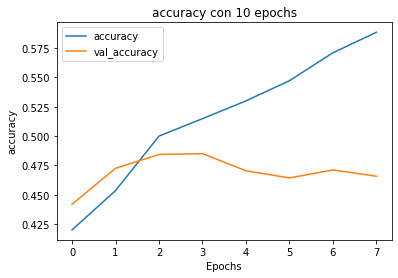

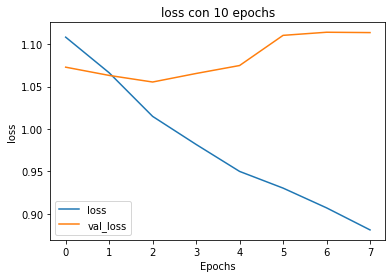

In [ ]:
def plot_graphs(history, string):
  plt.title(string+' con 10 epochs')
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

#model = tf.keras.Sequential([
#    tf.keras.layers.Dense(8623, activation='tanh', input_shape=(num_ngrams,)),
#    tf.keras.layers.Dropout(0.5),                     
#    tf.keras.layers.Dense(4311, activation='tanh'),
#    tf.keras.layers.Dropout(0.4),
#    tf.keras.layers.Dense(2155, activation='tanh'),
#    tf.keras.layers.Dropout(0.3),
#    tf.keras.layers.Dense(1077, activation='tanh'),
#    tf.keras.layers.Dropout(0.2),
#    tf.keras.layers.Dense(538, activation='tanh'),
#    tf.keras.layers.Dropout(0.1),
#    tf.keras.layers.Dense(269, activation='sigmoid'),
#    tf.keras.layers.Dropout(0.1),
#    tf.keras.layers.Dense(4, activation='softmax')
#])
#model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

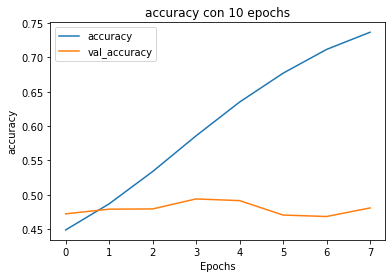

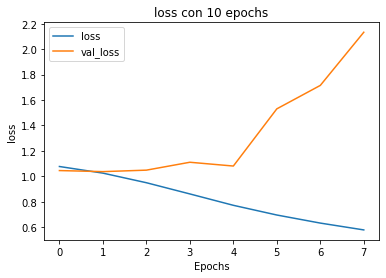

In [ ]:
def plot_graphs(history, string):
  plt.title(string+' con 10 epochs')
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")


#model = tf.keras.Sequential([
#    tf.keras.layers.Dense(8623, activation='tanh', input_shape=(num_ngrams,)),
#    tf.keras.layers.Dropout(0.5),                     
#    tf.keras.layers.Dense(4311, activation='tanh'),
#    tf.keras.layers.Dropout(0.4),
#    tf.keras.layers.Dense(2155, activation='tanh'),
#    tf.keras.layers.Dropout(0.3),
#    tf.keras.layers.Dense(1077, activation='tanh'),
#    tf.keras.layers.Dropout(0.2),
#    tf.keras.layers.Dense(538, activation='tanh'),
#    tf.keras.layers.Dropout(0.1),
#    tf.keras.layers.Dense(269, activation='tanh'),
#    tf.keras.layers.Dropout(0.1),
#    tf.keras.layers.Dense(4, activation='softmax')
#])
#model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Prueba del modelo

In [75]:
#predicciones del modelo
np.argmax(model.predict(test_sequences), axis=-1)

array([2, 0, 1, ..., 3, 1, 1])

In [80]:
#etiquetas reales
test_labels

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]], dtype=float32)